## A life-cycle consumption model with a state-dependent belief state (of income risks)

- author: Tao Wang
- date: October 2022
- this is a companion notebook to the paper ["Perceived income risks"](https://github.com/iworld1991/PIR/blob/master/PIR.pdf)

- This notebook builds on a standard life-cycle consumption model with uninsured income risks and extends it to allow for a **state-dependent belief state** about income risks

__What's standard__
  - Preference/income process
      - CRRA utility 
      - During work: labor income risk: permanent + MA(1)/persistent/transitory/2-state Markov between UE and EMP/ i.i.d. unemployment shock if not psersistent
       -  a deterministic growth rate of permanent income over the life cycle 
      - During retirement: receives a constant pension proportional to permanent income (no permanent/transitory income risks)
      - A positive probability of death before terminal age 
  
__What's new__
  - A new state variable of belief whose transitions follow 2-regime Markov, e.g. low risk versus high risk.
  - It is written for income risk parameters, but can be can be easily modified to reflect other state-dependent belief variables. 


In [1]:
import numpy as np
from interpolation import interp, mlinterp
from numba import njit, float64, int64, boolean
from numba.experimental import jitclass
import matplotlib.pyplot as plt
from time import time
from Utility import cal_ss_2markov,mean_preserving_spread
from copy import copy 

C:\Program Files\Anaconda3\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
from resources_jit import MeanOneLogNormal as lognorm

In [3]:
## plot configuration 

plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

## The Model Class and Solver

In [11]:
lc_data = [
    ## model paras
    ('ρ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Real interest rate factor 
    ('W',float64),               # Wage rate
    ('P', float64[:, :]),        # transition probs for z_t, a persistent state  x
    ('z_val', float64[:]),       # values of z, grid values for the continuous (macro) persistent state    x
    ('sigma_psi', float64),      # permanent shock volatility              x
    ('sigma_eps', float64),      # transitory shock volatility
    ('x',float64),               # MA(1) coefficient, or essentially the autocorrelation coef of non-permanent income
    ('b_y', float64),            # loading of macro state to income        x 
    ('borrowing_cstr',boolean),  ## artificial borrowing constraint if True, natural borrowing constraint if False
    ('U',float64),               # the i.i.d. probability of being unemployed    * 
    ('sigma_psi_2mkv',float64[:]), # markov permanent risks, only 2 for now
    ('sigma_eps_2mkv',float64[:]), # markov transitory risk, only 2 for now
    ('init_b', float64),              ## Initial endowment (possibly from accidental bequests) 
    ('sigma_p_init',float64),         ## standard deviation of initial income
    ('T',int64),                 # years of work                          *   
    ('L',int64),                 # years of life                          * 
    ('G',float64[:]),            # growth rate of permanent income    *
    ('LivPrb',float64[:]),         # the probability of being alive next period 
    ('unemp_insurance',float64),   ## Unemployment insurance replacement ratio 
    ('pension',float64),           ## pension payment to permanent income ratio
    ('ue_markov', boolean),        ## True if 2-state emp/uemp markov 
    ('state_dependent_risk', boolean),      ## True if 2-state risks 
    ('adjust_prob',float64),        ## the exogenous probability of being able to adjust consumption plan 
    ('λ', float64),                   ## Income tax rate
    ('λ_SS',float64),                 ## Social security tax 
    ('transfer', float64),            ## Transfer/current permanent income ratio
    ('bequest_ratio',float64),         ## zero: bequest thrown to the ocean; one: fully given to newborns
    ('theta',float64),           ## extrapolation parameter
    ## computational paras
    ('a_grid', float64[:]),      # Exogenous grid over savings
    ('eps_grid', float64[:]),    # Exogenous grid over transitory income shocks (for ma only)
    ('psi_shk_draws', float64[:]), ## draws of permanent income shock 
    ('eps_shk_draws', float64[:]), # draws of MA/transitory income shocks 
    ('shock_draw_size',int64),    ## nb of points drawn for shocks 
    ('psi_shk_mkv_draws',float64[:,:]),  ## 2-state markov on permanent risks 
    ('eps_shk_mkv_draws',float64[:,:]), ## 2-state markov on transitory risks
    ('init_p_draws', float64[:]),     ## Draws of initial permanent income
    ## regarding subjective beliefs
    ('P_sub',float64[:, :]),            # trans probs of belief states
    ('U2U_2mkv',float64[:]),            # state-dependent U2U prob
    ('E2E_2mkv',float64[:]),            # state-dependent E2E prob
    ('sigma_psi_true', float64),      # true permanent shock volatility              
    ('sigma_eps_true', float64),      # ture transitory shock volatility
    ('subjective',boolean),  ## belief is not necessarily equal to true 
    ('state_dependent_belief',boolean),  ## belief is state-dependent
    ('psi_shk_true_draws',float64[:]), ## draws of true permanent income shock 
    ('eps_shk_true_draws',float64[:]), ## draws of true transitory income shock 
    
    ## bequest motive 
    ('q',float64), ## q = 0 if no bequest motive 
    ('ρ_b',float64) ## elasticity of bequest 
]

In [20]:
@jitclass(lc_data)
class LifeCycle:
    """
    A class that stores primitives for the life cycle consumption problem.
    """

    def __init__(self,
                 ρ = 1.0,     ## relative risk aversion  
                 β = 0.99,    ## discount factor
                 P = np.array([[0.9,0.1],
                              [0.2,0.8]]),   ## transitory probability of markov state z
                 z_val = np.array([0.0,
                                   1.0]), ## markov state from low to high  
                 sigma_psi = 0.10,     ## size of permanent income shocks
                 sigma_eps = 0.10,   ## size of transitory income risks
                 x = 0.0,            ## MA(1) coefficient of non-permanent income shocks
                 borrowing_cstr = True,  ## artificial zero borrowing constraint 
                 U = 0.0,   ## unemployment risk probability (0-1)
                 LivPrb = np.ones(60)*0.995,       ## living probability 
                 b_y = 0.0,          ## loading of markov state on income  
                 R = 1.02,           ## interest factor 
                 W = 1.0,            ## Wage rate
                 T = 40,             ## work age, from 25 to 65 (including 65)
                 L = 60,             ## life length 85
                 G = np.ones(60),    ## growth factor list of permanent income 
                 shock_draw_size = 7,
                 grid_max = 5.0,
                 grid_size = 50,
                 ## subjective state dependent 
                 subjective = False,
                 state_dependent_belief = False,
                 P_sub = np.array([[0.5,0.5],
                              [0.5,0.5]]), 
                 sigma_psi_2mkv = np.array([0.05,0.2]),  ## permanent risks in 2 markov states
                 sigma_eps_2mkv = np.array([0.08,0.12]),  ## transitory risks in 2 markov states
                 U2U_2mkv = np.array([0.2,0.2]),         ## U2U in low and high risk mkv state
                 E2E_2mkv = np.array([0.9,0.9]),         ## E2E in low and high risk mkv state
                 theta = 2,               ## asymmetric extrapolation parameter
                 unemp_insurance = 0.0,   #  unemp_insurance = 0.0,   
                 pension = 1.0,           
                 ue_markov = False,    
                 state_dependent_risk = False,   
                 adjust_prob = 1.0,
                 sigma_p_init = 0.01,
                 init_b = 0.0,
                 λ = 0.0,
                 λ_SS = 0.0,
                 transfer = 0.0,
                 bequest_ratio = 0.0,
                 sigma_psi_true = 0.10,     ## true size of permanent income shocks
                 sigma_eps_true = 0.10,     ## ture size of transitory income risks  
                 q = 0.0,     # no bequest by default
                 ρ_b = 1.0 
                ): 
        self.ρ, self.β = ρ, β
        #####################
        self.q, self.ρ_b = q,ρ_b 
        ######################
        
        self.R = R 
        self.W = W
        self.P, self.z_val = P, z_val
        self.U = U
        #assert n_z == n_mkv, "the number of markov states for income and for risks should be equal"
        self.T,self.L = T,L
        self.G = G
        self.subjective = subjective 

        ###################################################
        ## fork depending on subjective or objective model ##
        #####################################################

        self.sigma_psi = sigma_psi
        self.sigma_eps = sigma_eps
            
        if self.subjective==False:
            self.sigma_psi_true = self.sigma_psi
            self.sigma_eps_true = self.sigma_eps
        else:
            print('reminder: needs to give true risk parameters: sigma_psi_true & sigma_eps_true!')
            self.sigma_psi_true = sigma_psi_true
            self.sigma_eps_true = sigma_eps_true
            
        self.x = x
        self.sigma_p_init = sigma_p_init
        self.init_b = init_b
        self.borrowing_cstr = borrowing_cstr
        self.b_y = b_y
        self.λ = λ
        self.λ_SS= λ_SS
        self.transfer = transfer 
        self.bequest_ratio = bequest_ratio 
        self.LivPrb = LivPrb 
        self.unemp_insurance = unemp_insurance
        self.pension = pension 
        self.ue_markov = ue_markov
        self.adjust_prob = adjust_prob
        self.state_dependent_risk = state_dependent_risk
        
        ## belief 
        self.P_sub = P_sub
        self.state_dependent_belief = state_dependent_belief
        self.sigma_psi_2mkv = sigma_psi_2mkv
        self.sigma_eps_2mkv = sigma_eps_2mkv
        self.U2U_2mkv = U2U_2mkv
        self.E2E_2mkv = E2E_2mkv
        
        ## shocks 
        
        self.shock_draw_size = shock_draw_size
        self.prepare_shocks()
        
        ## saving a grid
        a_grid_regular = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size-1))
        self.a_grid = np.append(a_grid_regular,np.max(a_grid_regular)*100)
              
        ## ma(1) shock grid 
        if sigma_eps!=0.0 and x!=0.0:
            lb_sigma_ϵ = -sigma_eps**2/2-2*sigma_eps
            ub_sigma_ϵ = -sigma_eps**2/2+2*sigma_eps
            self.eps_grid = np.linspace(lb_sigma_ϵ,ub_sigma_ϵ,grid_size)
        else:
            self.eps_grid = np.array([0.0,0.001])  ## make two points for the c function to be saved correctly  

    
        ## extrapolation coefficient, i.e. higher theta, higher asymmetric response
        self.theta = theta
        
        # Test stability (not needed if it is life-cycle)
        ## this is for infinite horizon problem 
        #assert β * R < 1, "Stability condition failed."  


    ## utility function 
    def u(self,c):
        if self.ρ!=1:
            return c**(1-self.ρ)/(1-ρ)
        elif self.ρ==1:
            return np.log(c)
    
    # marginal utility
    def u_prime(self, c):
        return c**(-self.ρ)

    # inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.ρ)

    ## a function for the transitory/persistent income component
    ### the fork depending on if discrete-markov bool is on/off
    def Y(self, z, u_shk):
        #from the transitory/ma shock and ue realization  to the income factor
        if self.ue_markov ==False:
            ## z state continuously loading to income
            ## u_shk here represents the cumulated MA shock, for instance, for ma(1), u_shk = phi eps_(t-1) + eps_t
            ## income 
            return np.exp(u_shk + (z * self.b_y))
        elif self.ue_markov ==True:
            ## ump if z ==0 and emp if z==1
            assert len(self.P)==2,"unemployment/employment markov has to be 2 state markov"
            return (z==0)*(self.unemp_insurance) + (z==1)*np.exp(u_shk)
        
    # a function from the log permanent shock to the income factor
    def Γ(self,psi_shk):
        return np.exp(psi_shk)
    
    
    def prepare_shocks(self):
        subjective = self.subjective
        shock_draw_size = self.shock_draw_size
        sigma_psi = self.sigma_psi
        sigma_eps = self.sigma_eps
        sigma_psi_true = self.sigma_psi_true
        sigma_eps_true = self.sigma_eps_true
        sigma_p_init = self.sigma_p_init
        sigma_psi_2mkv = self.sigma_psi_2mkv
        sigma_eps_2mkv = self.sigma_eps_2mkv
        
        ##################################################################
         ## discretized distributions 
        ##################################################################
                
        psi_shk_dist = lognorm(sigma_psi,100000,shock_draw_size)
        self.psi_shk_draws = np.log(psi_shk_dist.X)  ## the discretized is lognormal variable itself, we work with the log of it
        eps_shk_dist = lognorm(sigma_eps,100000,shock_draw_size)
        self.eps_shk_draws = np.log(eps_shk_dist.X)
        
        ## the draws used for simulation in household block 
        if subjective==False:
            self.psi_shk_true_draws =  self.psi_shk_draws
            self.eps_shk_true_draws =  self.eps_shk_draws
        else:
            psi_shk_true_dist = lognorm(sigma_psi_true,100000,shock_draw_size)
            eps_shk_true_dist = lognorm(sigma_eps_true,100000,shock_draw_size)
            self.psi_shk_true_draws =  np.log(psi_shk_true_dist.X)
            self.eps_shk_true_draws =  np.log(eps_shk_true_dist.X)
            
        
        init_p_dist = lognorm(sigma_p_init,100000,shock_draw_size)
        self.init_p_draws = np.log(init_p_dist.X)
        
        ## draw shocks for various markov state of volatility 
        #sigma_psi_2mkv_r = sigma_psi_2mkv.reshape(n_mkv,-1)
        #sigma_eps_2mkv_r = sigma_eps_2mkv.reshape(n_mkv,-1)
        
        sigma_psi_2mkv_l = lognorm(sigma_psi_2mkv[0],100000,shock_draw_size)
        sigma_psi_2mkv_h = lognorm(sigma_psi_2mkv[1],100000,shock_draw_size)
        
        self.psi_shk_mkv_draws = np.stack((np.log(sigma_psi_2mkv_l.X),
                                         np.log(sigma_psi_2mkv_h.X)))
        
        sigma_eps_2mkv_l = lognorm(sigma_eps_2mkv[0],100000,shock_draw_size)
        sigma_eps_2mkv_h = lognorm(sigma_eps_2mkv[1],100000,shock_draw_size)
        
        self.eps_shk_mkv_draws = np.stack((np.log(sigma_eps_2mkv_l.X),
                                         np.log(sigma_eps_2mkv_h.X)))
        
        
    def terminal_solution(self):
        
        k = len(self.a_grid)
        k2 =len(self.eps_grid)
        n_z =len(self.P)
        n_f = len(self.P_sub)        
        σ_init = np.empty((k,k2,n_z,n_f))
        m_init = np.empty((k,k2,n_z,n_f))
        
        if self.q==0.0:
            for z in range(n_z):
                for f in range(n_f):
                    for j in range(k2):
                        m_init[:,j,z,f] = self.a_grid
                        σ_init[:,j,z,f] = m_init[:,j,z,f]
        else:
            for z in range(n_z):
                for f in range(n_f):
                    for j in range(k2):
                        σ_init[:,j,z,f] = (self.q*self.a_grid**(-self.ρ_b))**(-1/self.ρ)
                        m_init[:,j,z,f] = self.a_grid + σ_init[:,j,z,f]
    
        return m_init,σ_init

In [21]:
## This function takes the consumption values at different 
## grids of state variables from period t+1, and
## the model class, then generates the consumption values at t.
## It depends on the age t since the income is different before 
## after the retirement. 

@njit
def EGM_combine(mϵ_in,
                σ_in,
                age_id, ## the period id for which the c policy is computed, the first period age_id=0, last period age_id=L-1, retirement after age_id=T-1
                lc):
    """
    The Coleman--Reffett operator for the life-cycle consumption problem,
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 x n4 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z), n4 = dim(f)
        * mϵ_in is the same sized grid points of the three state variable 
        * mϵ_in[:,j,z,f] is the vector of wealth grids corresponding to j-th grid of eps and markov state z and belief state f
        * σ_in[i,j,z,f] is consumption at aϵ_in[i,j,z,f]
    """    
    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    ρ, β = lc.ρ, lc.β
    R = lc.R

    ## markov state
    P = lc.P
    z_val = lc.z_val
    state_dependent_risk = lc.state_dependent_risk

    ## belief
    P_sub = lc.P_sub
    state_dependent_belief = lc.state_dependent_belief
    psi_shk_mkv_draws = lc.psi_shk_mkv_draws
    eps_shk_mkv_draws  = lc.eps_shk_mkv_draws
    E2E_2mkv = lc.E2E_2mkv
    U2U_2mkv = lc.U2U_2mkv

    ## grid
    a_grid = lc.a_grid
    eps_grid = lc.eps_grid 
    
    ## risks
    ue_prob = lc.U  ## uemp prob
    psi_shk_draws, eps_shk_draws= lc.psi_shk_draws, lc.eps_shk_draws
    x = lc.x 
    
    ## model
    borrowing_cstr = lc.borrowing_cstr 
   
    unemp_insurance = lc.unemp_insurance
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability

    ## income functions
    Y = lc.Y
    Γ = lc.Γ
    ####################################
    age = age_id + 1
    G = lc.G[age_id+1]  ## get the age specific growth rate, G[T] is the sudden drop in retirement from working age
    LivProb = lc.LivPrb[age_id+1]  ## live probability
    ####################################

    λ = lc.λ
    λ_SS = lc.λ_SS
    transfer = lc.transfer
    pension = lc.pension 
    
    ###################
    n_z = len(P)
    n_f = len(P_sub)

    # Create consumption functions by linear interpolation
    ########################################################
    σ = lambda m,ϵ,z,f: mlinterp((mϵ_in[:,0,z,f],eps_grid),σ_in[:,:,z,f], (m,ϵ)) 

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_a X grid_size_ϵ X grid_size_z

    # Obtain c_i at each a_i, z, store in σ_out[i, z], computing
    # the expectation term by computed by averaging over discretized equally probable points of the distributions
    for i, a in enumerate(a_grid):
        for j, eps in enumerate(eps_grid):
            for z in range(n_z):
                for f in range(n_f):
                    ##################################
                    if state_dependent_belief == False:
                        pass
                    else:
                        psi_shk_draws = psi_shk_mkv_draws[f,:]
                        eps_shk_draws = eps_shk_mkv_draws[f,:]
                        P = np.array([[U2U_2mkv[f],1-U2U_2mkv[f]],
                                     [1-E2E_2mkv[f],E2E_2mkv[f]]])
                    ##########################################
                    # Compute expectation
                    Ez = 0.0
                    for z_hat in range(n_z):
                        z_val_hat = z_val[z_hat]
                        ########################################
                        if lc.state_dependent_risk == False:
                            pass
                        else:
                            psi_shk_draws = psi_shk_mkv_draws[z_hat,:]
                            eps_shk_draws = eps_shk_mkv_draws[z_hat,:]
                            P = np.array([[U2U_2mkv[z_hat],1-U2U_2mkv[z_hat]],
                                     [1-E2E_2mkv[z_hat],E2E_2mkv[z_hat]]])
                            
                        ########################################
                        for f_hat in range(n_f):
                            for eps_shk in eps_shk_draws:
                                for psi_shk in psi_shk_draws:
                                    ## for employed next period 
                                    Γ_hat = Γ(psi_shk) 
                                    u_shk = x*eps+eps_shk
                                    age = age_id + 1
                                    if age <=lc.T-1:   #till say 39, because consumption policy for t=40 changes   
                                        ## work 
                                        Y_hat = (1-λ)*(1-λ_SS)*Y(z_val_hat,u_shk) ## conditional on being employed 
                                        c_hat = σ(R/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat,f_hat)
                                        utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)

                                        ## for unemployed next period
                                        Y_hat_u = (1-λ)*unemp_insurance
                                        c_hat_u = σ(R/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat,f_hat)
                                        utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)

                                        Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                                   ue_prob*utility_u* P[z, z_hat]
                                                  )*P_sub[f,f_hat]
                                    else:
                                        ## retirement
                                        Y_R = lc.pension
                                        ## no income shocks affecting individuals
                                        Γ_hat = 1.0 
                                        eps_shk = 0.0
                                        c_hat = σ(R/(G*Γ_hat) * a + (Y_R+transfer),eps_shk,z_hat,f_hat)
                                        utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                        Ez += LivProb*utility * P[z, z_hat]*P_sub[f,f_hat]

                    Ez = Ez / (len(psi_shk_draws)*len(eps_shk_draws))
                    ## the last step depends on if adjustment is fully flexible
                    if adjust_prob ==1.0:
                        σ_out[i, j, z,f] =  u_prime_inv(β * R* Ez)
                    elif adjust_prob <1.0:
                        σ_out[i, j, z,f] =  adjust_prob/(1-LivProb*β*R*(1-adjust_prob))*u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    mϵ_out = np.empty_like(σ_out)

    for j,ϵ in enumerate(eps_grid):
        for z in range(n_z):
            for f in range(n_f):
                mϵ_out[:,j,z,f] = a_grid + σ_out[:,j,z,f]

    # Fixing a consumption-asset pair at for the constraint region
    for j,ϵ in enumerate(eps_grid):
        for z in range(n_z):
            for f in range(n_f):
                if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                    σ_out[0,j,z,f] = 0.0
                    mϵ_out[0,j,z,f] = 0.0
                else:
                    if age <=lc.T-1:
                        σ_out[0,j,z,f] = 0.0
                        if state_dependent_belief:
                            self_min_a = - np.exp(np.min(eps_shk_mkv_draws[f,:]))*G/R
                        else:
                            self_min_a = - np.exp(np.min(eps_shk_draws))*G/R
                        if state_dependent_risk:
                            self_min_a = - np.exp(np.min(eps_shk_mkv_draws[z,:]))*G/R
                        else:
                            self_min_a = - np.exp(np.min(eps_shk_draws))*G/R

                        self_min_a = min(self_min_a,-unemp_insurance/R)
                        mϵ_out[0,j,z,f] = self_min_a
                    else:
                        σ_out[0,j,z,f] = 0.0
                        self_min_a = - pension*G/R
                        mϵ_out[0,j,z,f] = self_min_a

    return mϵ_out, σ_out

In [22]:
## for life-cycle/finite horizon problem 
def solve_model_backward_iter(model,        # Class with model information
                              mϵ_vec,        # Initial condition for assets and MA shocks
                              σ_vec,        # Initial condition for consumption
                             ):

    ## memories for life-cycle solutions 
    n_grids1 = σ_vec.shape[0]
    n_grids2 = σ_vec.shape[1]
    n_z = len(model.P)    
    n_f = len(model.P_sub)
    mϵs_new =  np.empty((model.L,n_grids1,n_grids2,n_z,n_f),dtype = np.float64)
    σs_new =  np.empty((model.L,n_grids1,n_grids2,n_z,n_f),dtype = np.float64)
    
    mϵs_new[0,:,:,:,:] = mϵ_vec
    σs_new[0,:,:,:,:] = σ_vec
    
    for year2L in range(1,model.L): ## nb of years till L from 0 to Model.L-2
        age = model.L-year2L
        age_id = age-1
        #print("at work age of "+str(age))
        mϵ_vec_next, σ_vec_next = mϵs_new[year2L-1,:,:,:,:],σs_new[year2L-1,:,:,:,:]
        
        mϵ_new, σ_new = EGM_combine(mϵ_vec_next, σ_vec_next, age_id, model)

        mϵs_new[year2L,:,:,:,:] = mϵ_new
        σs_new[year2L,:,:,:,:] = σ_new

    return mϵs_new, σs_new

In [23]:
## for infinite horizon problem 
def solve_model_iter(model,        # Class with model information
                     me_vec,        # Initial condition for assets and MA shocks
                     σ_vec,        # Initial condition for consumption
                      tol=1e-6,
                      max_iter=2000,
                      verbose=True,
                      print_skip=50):

    # Set up loop
    i = 0
    error = tol + 1

    ## memories for life-cycle solutions
    while i < max_iter and error > tol:
        me_new, σ_new = EGM_combine(me_vec, σ_vec, 0,model)
        
        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        me_vec, σ_vec = np.copy(me_new), np.copy(σ_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return me_vec, σ_vec

In [24]:
# a function to compare two solutions 

def compare_2solutions(ms_stars,
                      σs_stars):
    """
    input
    ======
    ms_stars: list of m grids
    σs_stars: list of c policies 
    
    output
    ======
    diff12: difference between solution 1 and solution 2 (1 minus 2)
    
    """
    if len(σs_stars)!=2 or len(σs_stars)!=2:
        print('only the first two solutions are compared!')
    m_star1, σ_star1 = ms_stars[0],σs_stars[0]
    m_star2, σ_star2 = ms_stars[1],σs_stars[1]

    ## get the interpolated c funcs
    c_stars1 = np.empty_like(σ_star1)
    c_stars2 = np.empty_like(σ_star2)
    n_age,n_m,n_eps,n_z,n_f = c_stars1.shape
    
    m_grid = np.linspace(0.0,5.0,n_m)
    
    for i in range(n_age):
        for j in range(n_eps):
            for k in range(n_z):
                for f in range(n_f):
                    c_func1 = lambda m: interp(m_star1[i,:,j,k,f],σ_star1[i,:,j,k,f],m)
                    c_stars1[i,:,j,k,f] = c_func1(m_grid)
                    c_func2 = lambda m: interp(m_star2[i,:,j,k,f],σ_star2[i,:,j,k,f],m)
                    c_stars2[i,:,j,k,f] = c_func2(m_grid)
        
    diff12 = c_stars1-c_stars2
    return diff12 

## Initialize a Model

In [25]:
if __name__ == "__main__":


    ## parameters 
    ###################

    U = 0.2 ## transitory ue risk
    U0 = 0.0 ## transitory ue risk


    ## life cycle 

    T = 40
    L = 60
    G = np.ones(L) # A Fake deterministic Life-cycle Income Profile
    YPath = np.cumprod(G)

## Solve the Life-Cycle Problem 

In [26]:
if __name__ == "__main__":
    P_uemkv = np.array([(0.2, 0.8),
                        (0.2, 0.8)])   # markov transition matrices
    
    lc_paras = {'sigma_psi':0.2, # permanent 
                'sigma_eps': 0.1, #transitory
                'U':U,
                'ρ':2,
                'R':1.01,
                'T':T,
                'L':L,
                'G':G,
                'β':0.97,
                 'P':P_uemkv,
                'x':0.0,  # no MA shock 
                'borrowing_cstr':True,
                'b_y':0.0, #no persistent state
                'unemp_insurance':0.15}

In [27]:
if __name__ == "__main__":
    lc_basic = LifeCycle(**lc_paras)

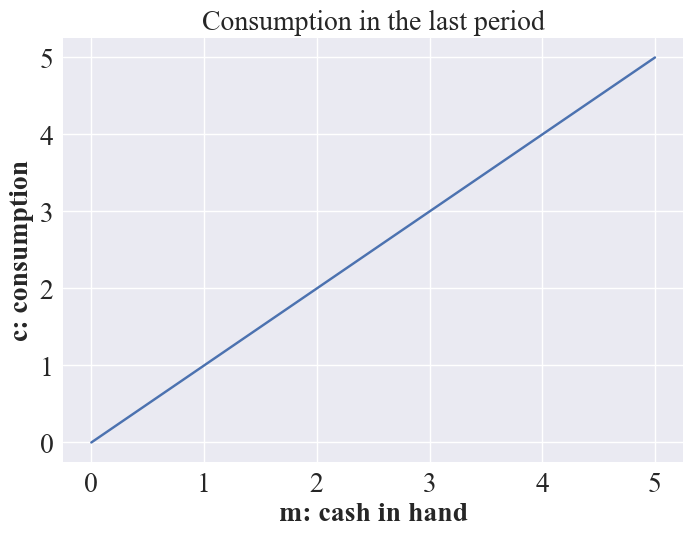

In [28]:
# Initial the end-of-period consumption policy of σ = consume all assets

if __name__ == "__main__":

    ## initial consumption functions 
    
    m_init,σ_init = lc_basic.terminal_solution()
    
    plt.title('Consumption in the last period')
    plt.plot(m_init[0:-1,0,0,0],
             σ_init[0:-1,0,0,0])
    plt.xlabel('m: cash in hand')
    plt.ylabel('c: consumption')

In [29]:
## the size of consumption function is  nb_a x nb_eps x nb_z x nb_f
if __name__ == "__main__":
    print(σ_init.shape)

(50, 2, 2, 2)


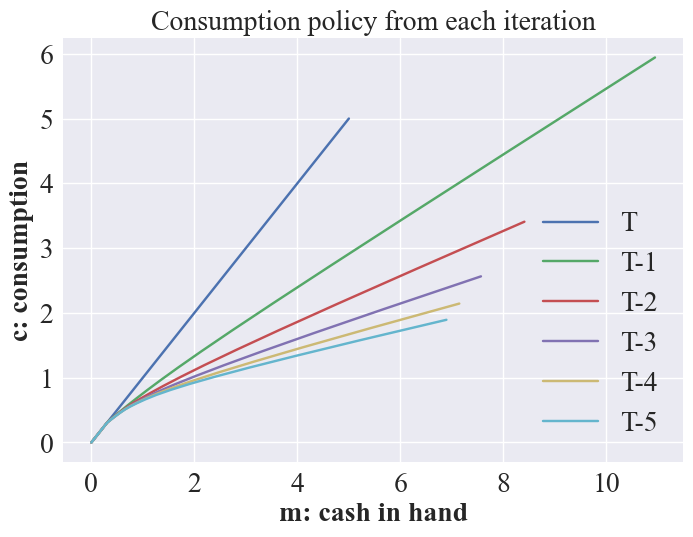

In [30]:
if __name__ == "__main__":
    #########################
    ## test the iteration
    #########################

    m_vec,σ_vec = lc_basic.terminal_solution()

    ### plot each iteration
    fig,ax = plt.subplots()
    plt.title('Consumption policy from each iteration')
    ax.plot(m_vec[0:-1,0,0,0],
            σ_vec[0:-1,0,0,0],
            label='T')
    ax.set_xlabel('m: cash in hand')
    ax.set_ylabel('c: consumption')
    ## solve backward

    for it in range(100):
        m_next, σ_next = EGM_combine(m_vec,
                             σ_vec,
                             10,
                             lc_basic)
        if it <5:
            ax.plot(m_next[0:-1,0,0,0],
                    σ_next[0:-1,0,0,0],
                    label='T-'+str(it+1))
        error = np.max(abs(σ_next-σ_vec))
        m_vec = np.copy(m_next)
        σ_vec = np.copy(σ_next)
    ax.legend(loc=0)

In [31]:
if __name__ == "__main__":

    t_start = time()

    ### this line is very important!!!!
    #### need to regenerate shock draws for new sigmas
    lc_basic.prepare_shocks()

    ## terminal solution
    m_init,σ_init = lc_basic.terminal_solution()

    ## solve backward
    ms_star_basic, σs_star_basic = solve_model_backward_iter(lc_basic,
                                                             m_init,
                                                             σ_init)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

Time taken, in seconds: 2.1768648624420166


## Allowing for State-dependent BELIEFS 

In [32]:
if __name__ == "__main__":
    
    ## markov tansition probs of belief states 
    P_sub = np.array(
        [[0.95,0.05],[0.1,0.9]]
    )
        
    sigma_psi_low, sigma_psi_high = 0.03, 0.25
    sigma_eps_low, sigma_eps_high = 0.03, 0.25
    
    sigma_psi_2mkv_sub = np.array([sigma_psi_low, sigma_psi_high])
    sigma_eps_2mkv_sub = np.array([sigma_eps_low, sigma_eps_high])

In [33]:
if __name__ == "__main__":
    
    lc_uemkv_sub_paras = copy(lc_paras)
    lc_uemkv_sub_paras['P'] = P_uemkv
    lc_uemkv_sub_paras['ue_markov'] = True
    lc_uemkv_sub_paras['state_dependent_risk'] = False
    
    ####################
     ## subjective belief 
     ####################
    lc_uemkv_sub_paras['state_dependent_belief'] = True
    
    lc_uemkv_sub_paras['P_sub'] = P_sub
    lc_uemkv_sub_paras['sigma_psi_2mkv'] = sigma_psi_2mkv_sub
    lc_uemkv_sub_paras['sigma_eps_2mkv'] = sigma_eps_2mkv_sub

    ## initialize another 
    lc_uemkv_sub = LifeCycle(**lc_uemkv_sub_paras)

In [34]:
if __name__ == "__main__":


    ## solve the model for different transition matrices

    t_start = time()

    ## initial guess
    m_init_sub,σ_init_sub = lc_uemkv_sub.terminal_solution()

    ## solve the model 
    ms_star_sub, σs_star_sub = solve_model_backward_iter(lc_uemkv_sub,
                                                       m_init_sub,
                                                       σ_init_sub)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

Time taken, in seconds: 0.7970778942108154


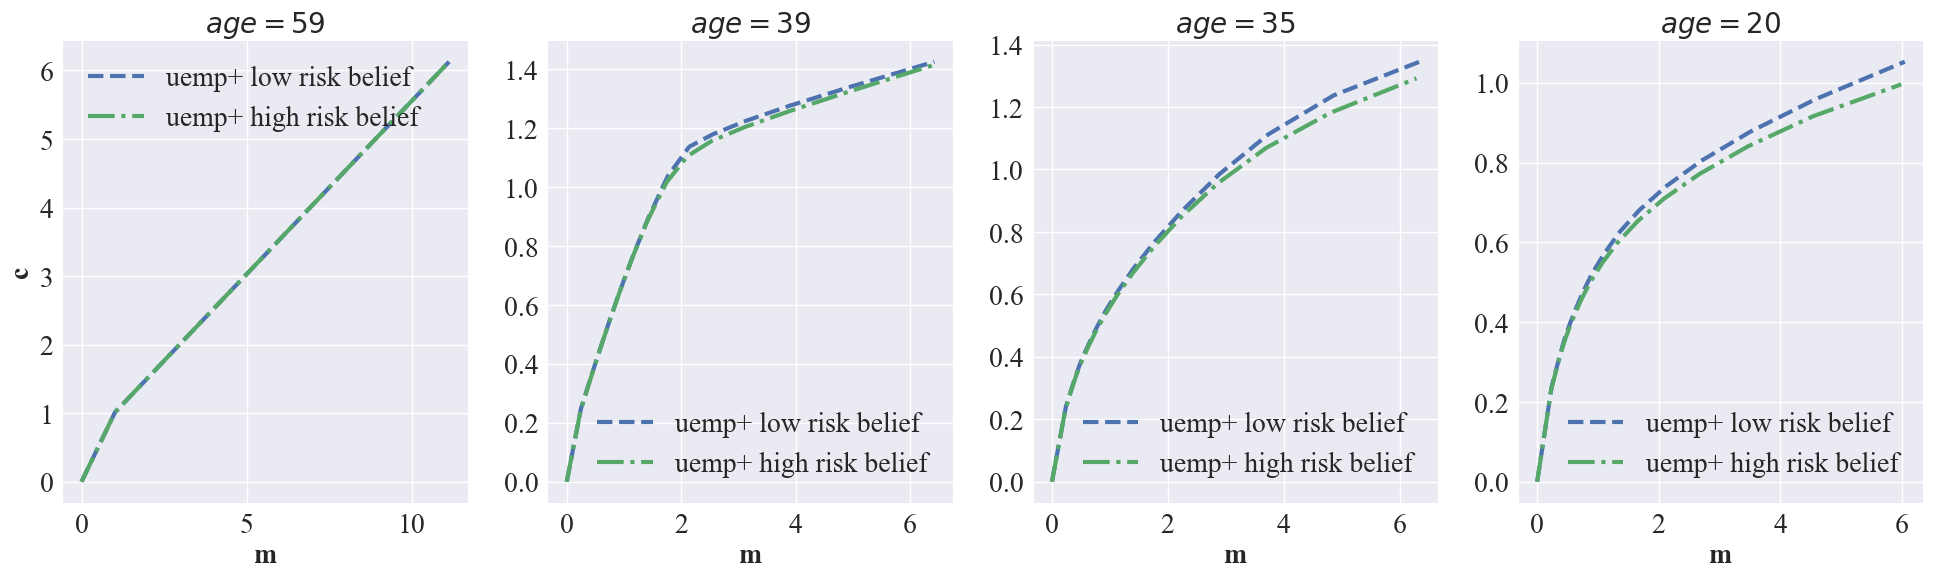

In [35]:
if __name__ == "__main__":


    ## compare two markov states low versus high risk 

    years_left = [1,21,25,40]

    n_sub = len(years_left)

    eps_id = 0

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_basic.L-year
        i = lc_basic.L-age
        m_plt_u_l,c_plt_u_l = ms_star_sub[i,0:-1,eps_id,0,0],σs_star_sub[i,0:-1,eps_id,0,0]
        m_plt_u_h,c_plt_u_h = ms_star_sub[i,0:-1,eps_id,0,1],σs_star_sub[i,0:-1,eps_id,0,1]
        
        m_plt_e_l,c_plt_e_l = ms_star_sub[i,0:-1,eps_id,1,0],σs_star_sub[i,0:-1,eps_id,1,0]
        m_plt_e_h,c_plt_e_h = ms_star_sub[i,0:-1,eps_id,1,1],σs_star_sub[i,0:-1,eps_id,1,1]
        
        axes[x].plot(m_plt_u_l, ## 0 indicates the low risk state 
                     c_plt_u_l,
                     '--',
                     label ='uemp+ low risk belief',
                     lw = 3)
        axes[x].plot(m_plt_u_h, ## 1 indicates the high risk state 
                     c_plt_u_h,
                     '-.',
                     label ='uemp+ high risk belief',
                     lw = 3)
        
        #axes[x].plot(m_plt_e_l, ## 0 indicates the low risk state 
        #             c_plt_e_l,
        #             '--',
        #             label ='emp+ low risk belief',
        #             lw = 3)
        #axes[x].plot(m_plt_e_h, ## 1 indicates the high risk state 
        #             c_plt_e_h,
        #             '-.',
        #             label ='emp+ high risk belief',
        #             lw = 3)
        
        axes[x].legend()
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'$age={}$'.format(age))

## Solve the Infinite-horizon Problem

Error at iteration 50 is 0.17902178855310424.
Error at iteration 100 is 0.02953240688306913.
Error at iteration 150 is 0.007068221928136609.
Error at iteration 200 is 0.0018385746008426906.
Error at iteration 250 is 0.000488573789303004.
Error at iteration 300 is 0.00013056830727720126.
Error at iteration 350 is 3.4946405142122217e-05.
Error at iteration 400 is 9.357136661947152e-06.
Error at iteration 450 is 2.5057080836887735e-06.

Converged in 485 iterations.
Time taken, in seconds: 8.05457854270935


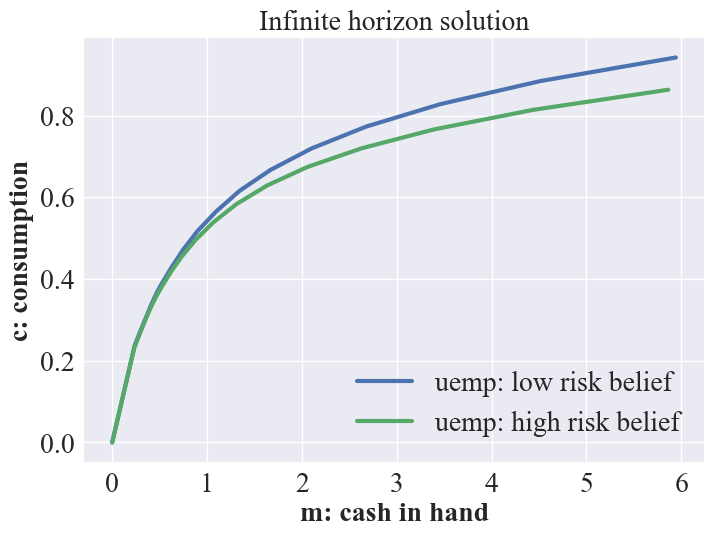

In [36]:
if __name__ == "__main__":

    inf_liv_paras = copy(lc_uemkv_sub_paras)
    
    ## initialize a model instance

    inf_liv = LifeCycle(**inf_liv_paras)

    ## initial guess of consumption functions 

    m_init,σ_init = inf_liv.terminal_solution()
   

    t_start = time()


    x_ls = [0.0]
    ms_inf_stars =[]
    σs_inf_stars = []
    
    for i,x in enumerate(x_ls):

        ## set different ma parameters 
        inf_liv.x = x
        m_inf_star, σ_inf_star = solve_model_iter(inf_liv,
                                                  m_init,
                                                  σ_init)
        ms_inf_stars.append(m_inf_star)
        σs_inf_stars.append(σ_inf_star)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))   



    ## plot c func 

    eps_fix = 0 ## no ma shock here. just use 0 for the index of transitory shock

    ms_inf_star = ms_inf_stars[0]
    σs_inf_star = σs_inf_stars[0]

    plt.plot(ms_inf_star[0:-1,eps_fix,0,0],
             σs_inf_star[0:-1,eps_fix,0,0],
             label='uemp: low risk belief',
             lw=3
            )
    plt.plot(ms_inf_star[0:-1,eps_fix,0,1],
             σs_inf_star[0:-1,eps_fix,0,1],
             label='uemp: high risk belief',
             lw=3
            )
    plt.legend()
    plt.xlabel('m: cash in hand')
    plt.ylabel('c: consumption')
    plt.title('Infinite horizon solution')
